In [2]:
import stim as st
import numpy as np
from pymatching import Matching
from tqdm import tqdm
import matplotlib.pyplot as plt

import json
import networkx as nx
import numpy as np

### Measurement Based Repetion code

##### 1) Most part of the function is stim's inbuilt repetition code
##### 2) A encoder circuit has been added , just so that it compares with MFQEC scheme where an encoder is present and coherent noises is assumed to be present at the enocoder part too. 



In [3]:


def generate_stim_rep_code_circuit(d, r):
    """
    Generates a d-distance Repetition Code circuit in Stim with manual encoding.
    Removes the built-in data resets so the encoder state is preserved.
    
    Args:
        d (int): Distance of the code (number of data qubits).
        r (int): Number of rounds.
        p (float): Noise probability (flip rate).
        
    Returns:
        st.Circuit: The complete circuit.
    """
    # Stim Layout: Data (Even: 0, 2, 4...), Ancilla (Odd: 1, 3, 5...)
    # Total Qubits = (2*d - 1)
    # E.g., d=3 => Indices 0, 1, 2, 3, 4 (Total 5)
    total_qubits = 2 * d - 1

    circuit = st.Circuit()

    # --- 1. Initial Clean Reset (All Qubits) ---
    circuit.append("R", range(total_qubits))

    # --- 2. Manual Encoder ---
    # CNOT from Data 0 to Data 2, 4, 6... (Even indices)
    data_qubits_indices = [0]
    for i in range(2, total_qubits, 2):
        circuit.append("CNOT", [0, i])
        data_qubits_indices.append(i)

    # --- 3. Generate Standard Circuit ---
    # This generates the syndrome rounds, noise, detectors, and ancilla resets
    circuit_gen = st.Circuit.generated(
        "repetition_code:memory",
        #after_clifford_depolarization = p,
        #before_round_data_depolarization = p,
        #before_round_data_depolarization=p,
        #after_reset_flip_probability=p,
        #before_measure_flip_probability=p,
        rounds=r,
        distance=d
    )

    # --- 4. Surgical Filter ---
    # Remove 'R' on data qubits (even), keep 'R' on ancillas (odd)
    for instruction in circuit_gen:
        if instruction.name == "R":
            new_targets = []
            for t in instruction.targets_copy():
                # Keep target if it is an Ancilla (Odd index)
                if t.value % 2 != 0: 
                    new_targets.append(t)
            
            # Only append the reset if there are ancillas to reset
            if new_targets:
                circuit.append("R", new_targets)
        else:
            # Keep all other instructions (CNOTs, MR, DETECTORS, etc.)
            circuit.append(instruction)
            
    return circuit , data_qubits_indices
ch, indices = generate_stim_rep_code_circuit(d= 5, r=2)
#ch.diagram("timeline-svg")
indices

[0, 2, 4, 6, 8]

### Adding nosie to clean circuits
##### 1) For the entirity of this excercise we may need various error models and assumptions-- hence we need a seperate function that adds various noises at varying strengths.  
##### 2) Also since encoder is joined with the circuit the standard noise models in inbuilt repetition code of stim cannot be directly used. 

##### 3) This function will be made more inclusive and more robust as the results start coming. 

In [4]:


def add_noise_to_stim_circuit(
    circuit: st.Circuit,
    data_qubits: list,
    p_clifford_depol: float = 0.0,
    p_data_idle: float = 0.0,
    p_measure_flip: float = 0.0,
    p_reset_flip: float = 0.0,
    biased_noise_tuple: tuple = (0.0, 0.0, 0.0)
) -> st.Circuit:
    """
    Injects 5 specific noise models into a clean Stim circuit.
    
    Args:
        circuit: The input clean circuit (stim.Circuit).
        data_qubits: List of integers specifying which qubits are 'Data' (for idle noise).
        p_clifford_depol: Probability of standard depolarizing noise after Cliffords.
        p_data_idle: Probability of decoherence on data qubits (applied at TICKs).
        p_measure_flip: Probability of X-flip before measurement.
        p_reset_flip: Probability of X-flip after reset.
        biased_noise_tuple: (px, py, pz) for custom biased noise after Cliffords.
        
    Returns:
        noisy_circuit: A new stim.Circuit with noise injected.
    """
    noisy_circuit = st.Circuit()
    
    # Define sets of gates for identifying Cliffords
    # (You can add more if needed, e.g., SQRT_X, etc.)
    clifford_1q = {"H", "S", "S_DAG", "X", "Y", "Z", "SQRT_X", "SQRT_Y", "SQRT_Z"}
    clifford_2q = {"CNOT", "CX", "CY", "CZ", "SWAP"}
    
    # Unpack biased noise
    px, py, pz = biased_noise_tuple
    has_biased_noise = (px > 0 or py > 0 or pz > 0)

    for instruction in circuit:
        name = instruction.name
        targets = instruction.targets_copy()
        
        # --- 1. HANDLE RESET NOISE (After Reset) ---
        if name == "R":
            noisy_circuit.append(instruction) # Apply Reset first
            if p_reset_flip > 0:
                # Apply X error to all reset targets
                noisy_circuit.append("X_ERROR", targets, p_reset_flip)

        # --- 2. HANDLE MEASUREMENT NOISE (Before Measure) ---
        elif name == "M" or name == "MR":
            if p_measure_flip > 0:
                # Apply X error to all measurement targets BEFORE the measure
                noisy_circuit.append("X_ERROR", targets, p_measure_flip)
            noisy_circuit.append(instruction) # Apply Measure
            
            # If it was "MR" (Measure + Reset), we technically need 'After Reset' noise too
            # MR acts as Measure -> Reset. So we add reset noise after it.
            if name == "MR" and p_reset_flip > 0:
                 noisy_circuit.append("X_ERROR", targets, p_reset_flip)

        # --- 3. HANDLE IDLE NOISE (At Ticks) ---
        elif name == "TICK":
            noisy_circuit.append(instruction)
            if p_data_idle > 0:
                # Apply idle noise only to the specified Data Qubits
                noisy_circuit.append("DEPOLARIZE1", data_qubits, p_data_idle)

        # --- 4 & 5. HANDLE CLIFFORD NOISE (After Gate) ---
        elif name in clifford_1q or name in clifford_2q:
            noisy_circuit.append(instruction) # Apply Gate first
            
            # Extract raw qubit indices from targets (ignoring lookback/sweep modifiers)
            # For simplicity assuming standard qubit targets here
            target_indices = [t.value for t in targets]

            # A) Standard Depolarization
            if p_clifford_depol > 0:
                if name in clifford_1q:
                    noisy_circuit.append("DEPOLARIZE1", target_indices, p_clifford_depol)
                elif name in clifford_2q:
                    # For 2Q gates, Stim expects pairs. 
                    # We usually apply DEPOLARIZE2 to the pairs.
                    noisy_circuit.append("DEPOLARIZE2", target_indices, p_clifford_depol)

            # B) Biased Noise (Custom Pauli Channel)
            if has_biased_noise:
                # Apply 1Q Biased Noise to EACH qubit involved in the gate independently
                for q in target_indices:
                    noisy_circuit.append("PAULI_CHANNEL_1", [q], [px, py, pz])

        # --- CATCH ALL (Detectors, Observables, etc.) ---
        else:
            noisy_circuit.append(instruction)

    return noisy_circuit

# === Usage Example ===
if __name__ == "__main__":
    # Create a clean dummy circuit
    clean_circuit = st.Circuit("""
        R 0 1 2 3 4
        TICK
        CNOT 0 1 2 3
        TICK
        M 0 1 2 3 4
    """)

    # Define Data Qubits (Events)
    data_qubits_indices = [0, 2, 4]

    noisy = add_noise_to_stim_circuit(
        ch,
        data_qubits=data_qubits_indices,
        p_clifford_depol=0.01,         # 1% Depol after gates
        p_data_idle=0.005,             # 0.5% Idle noise at TICKs
        p_measure_flip=0.02,           # 2% Readout error
        p_reset_flip=0.02,             # 2% Reset error
        biased_noise_tuple=(0.005, 0.0, 0.0) # Extra 0.5% X-bias after every gate
    )

#noisy.diagram()

### Simulating measurement based repetition code
##### Decoding is done using pymatching, standard stuffs except the new noise models and encoder part. 
##### This would be later compared with MBQEC

In [5]:
drange = range(3 , 12 , 2)
prange = np.linspace(0 , 0.15 , 10)
num_shots = 10000
log_error_list = []
for d in tqdm(drange): 
    log_error_perc = []
    for p in prange:
        clean_circuit , data_qubits_indices = generate_stim_rep_code_circuit(d, d)
        circuit = add_noise_to_stim_circuit(clean_circuit.flattened(),\
                                          data_qubits=data_qubits_indices,\
                                          p_clifford_depol=p,         # Depol after gates 
                                          p_data_idle=p,             #  Idle noise at TICKs
                                          p_measure_flip=p,           #  Readout error
                                          p_reset_flip=p,             # Reset error
                                          biased_noise_tuple=(0.00, 0.0, 0.0) # Extra 0.5% X-bias after every gate
    )
        model = circuit.detector_error_model(decompose_errors=True)
        matching = Matching.from_detector_error_model(model)
        sampler = circuit.compile_detector_sampler()
        syndrome, actual_observables = sampler.sample(shots=num_shots, separate_observables=True)
        predicted_observables = matching.decode_batch(syndrome)
        num_errors = np.sum(np.any(predicted_observables != actual_observables, axis=1))
        log_error_perc.append(num_errors/num_shots)
    log_error_list.append(log_error_perc)


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]


### Plotting the threshold behaviour for MBQEC repetition code

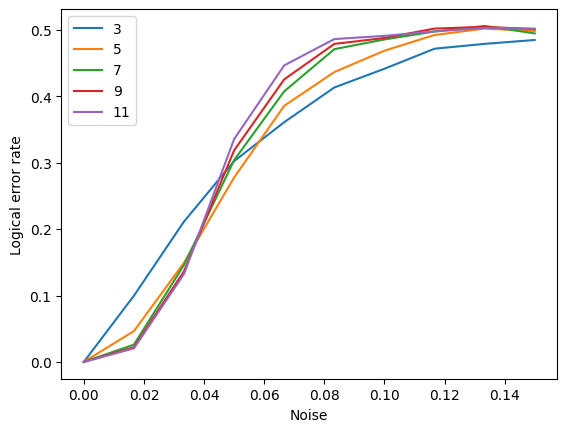

In [6]:
plt.xlabel("Noise")
plt.ylabel("Logical error rate")
plt.plot(prange , log_error_list[0] , label = drange[0] )
plt.plot(prange , log_error_list[1], label = drange[1] )

plt.plot(prange , log_error_list[2] , label = drange[2])
plt.plot(prange , log_error_list[3] , label = drange[3])
plt.plot(prange , log_error_list[4] , label = drange[4])
plt.legend()
plt.show()

### Need for measurement and classical logic in MFQEC simulations

###### Since the aim is to perform simulations using stim, one major compromise one has to do is one cannot use toffoli's which are essential for MFQEC. This is because toffolis are not **Clifford**. 

###### The work around is that instead if just reset , do measure reset and mimic what a toffoli would do using a classical **lookup table**. 
###### On hindsight I believe this assumption is not all that bad , as long as one could mimic the noises that a Toffoli is expected to generate. 

###### Below are those lookup tables that will be used upto distance 9 code. 

###### Actually just one round of syndrome extraction would do since we are storing them as classical data, but this assumption would come back and bite us if we add noises like say flip after reset. Because the assumption would significantly decrease the number of resets. Thus the robust way to simulate is to reset as many times a typical MFQEC circuit would. 

###### Importantly measurment noises or idling noise for lookup time are never added in this circuit, hence the step of measurement and classical lookup table is not affecting any assumptions of MFQEC simulations.  


In [7]:
def corrector(circuit , d , j):
    sampler = circuit.compile_sampler()
    s = sampler.sample(shots=1)[0]
    if int(s[0 + 6*j]) == 1 and int(s[1 + 6*j]) == 0:
        circuit.append("X" , [0])
    elif int(s[2 + 6*j]) == 1 and int(s[3+6*j]) == 1:
        circuit.append("X" , [1])
    elif int(s[4+6*j]) == 0 and int(s[5+6*j]) == 1:
        circuit.append("X" , [2])
    return circuit


def corrector4(circuit , d , j):
    sampler = circuit.compile_sampler()
    # Capture the sample ONCE for consistency (Critical for correctness)
    s = sampler.sample(shots=1)[0]
    if int(s[0 + 12*j]) == 1 and int(s[1 + 12*j]) == 0 and int(s[2 + 12*j]) == 0:
        circuit.append("X" , [0])
    elif int(s[3 + 12*j]) == 1 and int(s[4 + 12*j]) == 1 and int(s[5 + 12*j]) == 0:
        circuit.append("X" , [1])
    elif int(s[6 + 12*j]) == 0 and int(s[7 + 12*j]) == 1 and int(s[8 + 12*j]) == 1:
        circuit.append("X" , [2])
    elif int(s[9 + 12*j]) == 0 and int(s[10 + 12*j]) == 0 and int(s[11 + 12*j]) == 1:
        circuit.append("X" , [3])
    return circuit

def corrector5(circuit, d, j):
    sampler = circuit.compile_sampler()
    
    # Capture the sample ONCE for consistency (Critical for correctness)
    s = sampler.sample(shots=1)[0]
    
    # Offset for the current round (20 bits per round for d=5)
    offset = 20 * j

    # Check Qubit 0 (Pattern 1 0 0 0 on bits 0-3)
    if (int(s[0 + offset]) == 1 and 
        int(s[1 + offset]) == 0 and 
        int(s[2 + offset]) == 0 and 
        int(s[3 + offset]) == 0):
        circuit.append("X", [0])

    # Check Qubit 1 (Pattern 1 1 0 0 on bits 4-7)
    elif (int(s[4 + offset]) == 1 and 
          int(s[5 + offset]) == 1 and 
          int(s[6 + offset]) == 0 and 
          int(s[7 + offset]) == 0):
        circuit.append("X", [1])

    # Check Qubit 2 (Pattern 0 1 1 0 on bits 8-11)
    elif (int(s[8 + offset]) == 0 and 
          int(s[9 + offset]) == 1 and 
          int(s[10 + offset]) == 1 and 
          int(s[11 + offset]) == 0):
        circuit.append("X", [2])

    # Check Qubit 3 (Pattern 0 0 1 1 on bits 12-15)
    elif (int(s[12 + offset]) == 0 and 
          int(s[13 + offset]) == 0 and 
          int(s[14 + offset]) == 1 and 
          int(s[15 + offset]) == 1):
        circuit.append("X", [3])

    # Check Qubit 4 (Pattern 0 0 0 1 on bits 16-19)
    elif (int(s[16 + offset]) == 0 and 
          int(s[17 + offset]) == 0 and 
          int(s[18 + offset]) == 0 and 
          int(s[19 + offset]) == 1):
        circuit.append("X", [4])

    return circuit


def corrector7(circuit, d, j):
    sampler = circuit.compile_sampler()
    s = sampler.sample(shots=1)[0]
    
    # 42 bits per round (7 reps * 6 ancillas)
    # Base offset for the current round 'j'
    base = 42 * j 
    
    # Q0: Check Rep 0 (Ancillas 0-5) -> Pattern 1 0 0 0 0 0
    if (int(s[base + 0]) == 1 and int(s[base + 1]) == 0):
        circuit.append("X", [0])

    # Q1: Check Rep 1 (Ancillas 0-5) -> Pattern 1 1 0 0 0 0
    elif (int(s[base + 6]) == 1 and int(s[base + 7]) == 1 and int(s[base + 8]) == 0):
        circuit.append("X", [1])

    # Q2: Check Rep 2 -> Pattern 0 1 1 0 0 0
    elif (int(s[base + 12]) == 0 and int(s[base + 13]) == 1 and 
          int(s[base + 14]) == 1 and int(s[base + 15]) == 0):
        circuit.append("X", [2])

    # Q3: Check Rep 3 -> Pattern 0 0 1 1 0 0
    elif (int(s[base + 20]) == 1 and int(s[base + 21]) == 1 and 
          int(s[base + 22]) == 0 and int(s[base + 23]) == 0):
        circuit.append("X", [3])

    # Q4: Check Rep 4 -> Pattern 0 0 0 1 1 0
    elif (int(s[base + 27]) == 1 and int(s[base + 28]) == 1 and 
          int(s[base + 29]) == 0 and int(s[base + 30]) == 0):
        circuit.append("X", [4])

    # Q5: Check Rep 5 -> Pattern 0 0 0 0 1 1
    elif (int(s[base + 34]) == 1 and int(s[base + 35]) == 1 and 
          int(s[base + 36]) == 0):
        circuit.append("X", [5])

    # Q6: Check Rep 6 -> Pattern 0 0 0 0 0 1
    elif (int(s[base + 40]) == 0 and int(s[base + 41]) == 1):
        circuit.append("X", [6])

    return circuit

def corrector9(circuit, d, j):
    sampler = circuit.compile_sampler()
    s = sampler.sample(shots=1)[0]
    
    # 72 bits per round (9 reps * 8 ancillas)
    base = 72 * j

    # Q0: Rep 0 -> 1 0 ...
    if (int(s[base + 0]) == 1 and int(s[base + 1]) == 0):
        circuit.append("X", [0])

    # Q1: Rep 1 -> 1 1 0 ...
    elif (int(s[base + 8]) == 1 and int(s[base + 9]) == 1 and int(s[base + 10]) == 0):
        circuit.append("X", [1])

    # Q2: Rep 2 -> 0 1 1 0 ...
    elif (int(s[base + 17]) == 1 and int(s[base + 18]) == 1 and 
          int(s[base + 19]) == 0 and int(s[base + 20]) == 0):
        circuit.append("X", [2])

    # Q3: Rep 3 -> 0 0 1 1 0 ...
    elif (int(s[base + 26]) == 1 and int(s[base + 27]) == 1 and 
          int(s[base + 28]) == 0 and int(s[base + 29]) == 0):
        circuit.append("X", [3])

    # Q4: Rep 4 -> 0 0 0 1 1 0 ...
    elif (int(s[base + 35]) == 1 and int(s[base + 36]) == 1 and 
          int(s[base + 37]) == 0 and int(s[base + 38]) == 0):
        circuit.append("X", [4])

    # Q5: Rep 5 -> 0 0 0 0 1 1 0 ...
    elif (int(s[base + 44]) == 1 and int(s[base + 45]) == 1 and 
          int(s[base + 46]) == 0 and int(s[base + 47]) == 0):
        circuit.append("X", [5])

    # Q6: Rep 6 -> 0 0 0 0 0 1 1 0
    elif (int(s[base + 53]) == 1 and int(s[base + 54]) == 1 and 
          int(s[base + 55]) == 0 and int(s[base + 56]) == 0):
        circuit.append("X", [6])

    # Q7: Rep 7 -> 0 0 0 0 0 0 1 1
    elif (int(s[base + 62]) == 1 and int(s[base + 63]) == 1 and 
          int(s[base + 64]) == 0):
        circuit.append("X", [7])

    # Q8: Rep 8 -> 0 0 0 0 0 0 0 1
    elif (int(s[base + 70]) == 0 and int(s[base + 71]) == 1):
        circuit.append("X", [8])

    return circuit

#### A function to generate MFQEC **clean** circuit for multiple rounds and distance. 

In [8]:
def encoder_mf_st(d): 
    data_qubits = d
    plus_qubits = d
    ancilla_qubits = d-1
    total_qubits = data_qubits + plus_qubits + ancilla_qubits

    circuit = st.Circuit()

    # --- 1. Initial Clean Reset (All Qubits) ---
    circuit.append("R", range(total_qubits))

    # --- 2. Manual Encoder ---
    # CNOT from Data 0 to Data 2, 4, 6... (Even indices)
    data_qubits_indices = [0]
    for i in range( 1,data_qubits):
        circuit.append("CNOT", [0, i])
        data_qubits_indices.append(i)
    circuit.append("H" , [data_qubits])
    
    # Plus state encoder
    for i in range(data_qubits+1, (data_qubits + plus_qubits)):
        circuit.append("CNOT", [data_qubits,i])
    return circuit , data_qubits_indices
def synd_extractor_mf_st(d):
    circuit = st.Circuit()
    data_qubits = d
    plus_qubits = d
    ancilla_qubits = d-1
    total_qubits = data_qubits + plus_qubits + ancilla_qubits
    for i in range(data_qubits):
        circuit.append("CNOT", [i,i+data_qubits])
    for i in range(ancilla_qubits):
        circuit.append("CNOT", [i+data_qubits,(i+data_qubits+plus_qubits)])
        circuit.append("CNOT", [i+data_qubits+1,(i+data_qubits+plus_qubits)])
    circuit.append("R" ,range(data_qubits , data_qubits+ancilla_qubits))
        # Reset and syndrome copying and repeat that for each data qubit
    for _ in range(data_qubits):
        #circuit.append("MR" ,range(data_qubits , data_qubits+ancilla_qubits))
        for i in range(ancilla_qubits):
            circuit.append("CNOT", [(i+data_qubits+plus_qubits),i+data_qubits])
        circuit.append("MR" ,range(data_qubits , data_qubits+ancilla_qubits))
    return circuit

def toffoli_mimicer_mf_st(circuit , d , j):
    data_qubits = d
    plus_qubits = d
    ancilla_qubits = d-1
    total_qubits = data_qubits + plus_qubits + ancilla_qubits
    if(data_qubits == 3):
        circuit = corrector(circuit , data_qubits , j)
    elif(data_qubits == 4):
        circuit = corrector4(circuit , data_qubits , j)
    elif(data_qubits == 5):
        circuit = corrector5(circuit , data_qubits , j)
    elif(data_qubits == 7):
        circuit = corrector7(circuit , data_qubits , j)
    elif(data_qubits == 9):
        circuit = corrector9(circuit , data_qubits , j)
    circuit.append("R",range(data_qubits,total_qubits))

    return circuit



##### As shown in the orginal paper for bitflip errors on just one qubit the code must be able to correct it. So below we shall do a sanity check where

##### 5 qubit MFQEC code is simulated with bitflip injected **intentionally** at q[1]. If the code works well it must apply a correction operator in

##### the first round and second round must be free of any error / corrections for that matter.   

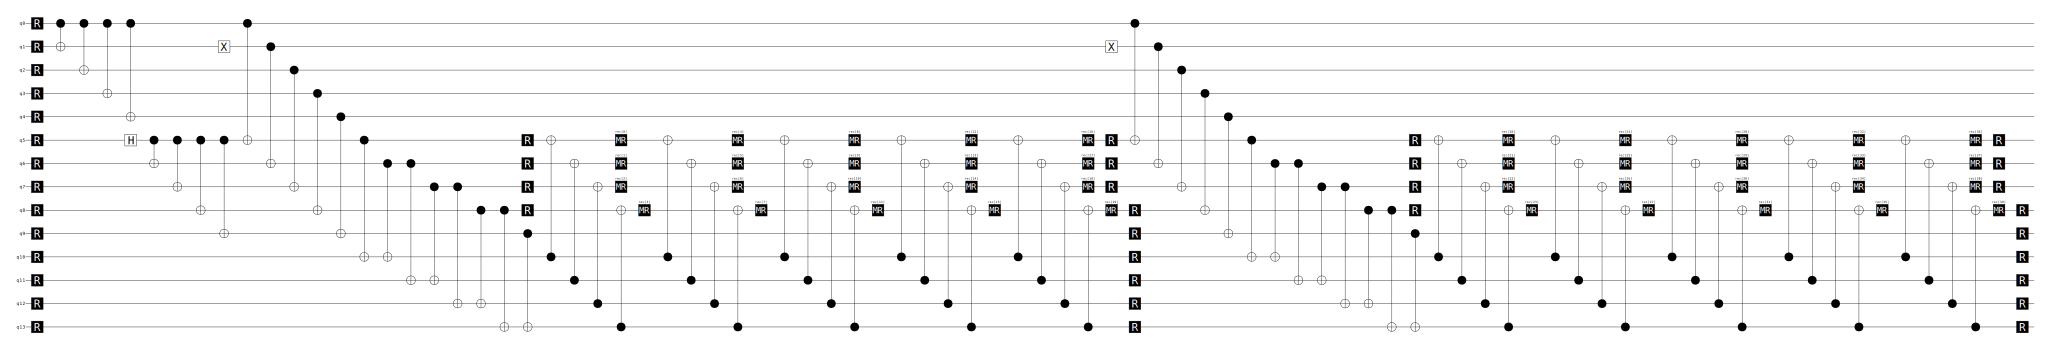

In [9]:
def generate_stim_rep_code_circuit_MF(d , r ):
    data_qubits = d
    plus_qubits = d
    ancilla_qubits = d-1
    total_qubits = data_qubits + plus_qubits + ancilla_qubits

    circuit = st.Circuit()

    # --- 1. Initial Clean Reset (All Qubits) ---
    circuit.append("R", range(total_qubits))

    # --- 2. Manual Encoder ---
    # CNOT from Data 0 to Data 2, 4, 6... (Even indices)
    data_qubits_indices = [0]
    for i in range( 1,data_qubits):
        circuit.append("CNOT", [0, i])
        data_qubits_indices.append(i)
    circuit.append("H" , [data_qubits])
    
    # Plus state encoder
    for i in range(data_qubits+1, (data_qubits + plus_qubits)):
        circuit.append("CNOT", [data_qubits,i])

     #Error injection
    #circuit.append("X", [5])
    #circuit.append()
    circuit.append("X", [1])
    #circuit.append("X", [1])
    #circuit.append("PAULI_CHANNEL_1", range(0 , int((d-1)/2)), [p, 0, 0])
    
    

    #Syndrome storing
    for j in range(r):
        #Error copier
        for i in range(data_qubits):
            circuit.append("CNOT", [i,i+data_qubits])
        for i in range(ancilla_qubits):
            circuit.append("CNOT", [i+data_qubits,(i+data_qubits+plus_qubits)])
            circuit.append("CNOT", [i+data_qubits+1,(i+data_qubits+plus_qubits)])
        circuit.append("R" ,range(data_qubits , data_qubits+ancilla_qubits))
        # Reset and syndrome copying and repeat that for each data qubit
        for _ in range(data_qubits):
            #circuit.append("MR" ,range(data_qubits , data_qubits+ancilla_qubits))
            for i in range(ancilla_qubits):
                circuit.append("CNOT", [(i+data_qubits+plus_qubits),i+data_qubits])
            circuit.append("MR" ,range(data_qubits , data_qubits+ancilla_qubits))
        if(data_qubits == 3):
            circuit = corrector(circuit , data_qubits , j)
        elif(data_qubits == 4):
            circuit = corrector4(circuit , data_qubits , j)
        elif(data_qubits == 5):
            circuit = corrector5(circuit , data_qubits , j)
        elif(data_qubits == 7):
            circuit = corrector7(circuit , data_qubits , j)
        elif(data_qubits == 9):
            circuit = corrector9(circuit , data_qubits , j)
        
        
        circuit.append("R",range(data_qubits,total_qubits))
    return circuit ,data_qubits_indices


#circuit , indices = generate_stim_rep_code_circuit_MF(3 , 2)
#circuit.append("M" ,indices )

#sampler = circuit.compile_sampler()
#(sampler.sample(shots = 1)[0][[-1,-2,-3]])
check , indices = generate_stim_rep_code_circuit_MF(5 , 2 )
check.diagram("timeline-svg")


### Now we are in a position to do threshold theorem plots. 

### Two things to verify 

##### 1) In repetition code under MFQEC for some model and strength of noise does increasing distance supress logical error rate ?

##### 2) Does multiple rounds really help to supress noise ? or does it add more noise 




In [98]:
drange = range(3 , 10 , 2)
prange = np.linspace(0 , 5e-2 , 4)
num_shots = int(1e5)
log_error_list = []
rounds = 1
for d in drange:
    #rounds = d
    clean_circuit , indices = encoder_mf_st(d) 
    clean_se_circuit = synd_extractor_mf_st(d)
    log_error_perc = []
    for p in tqdm(prange):
        noisy_circuit = add_noise_to_stim_circuit(clean_circuit.flattened(),\
                                          data_qubits=data_qubits_indices,\
                                          p_clifford_depol=p,         # Depol after gates 
                                          p_data_idle=0,             #  Idle noise at TICKs
                                          p_measure_flip=0,           #  Readout error
                                          p_reset_flip=0,             # Reset error
                                          biased_noise_tuple=(0.00, 0.0, 0.0)) # 
        noisy_se_circuit = add_noise_to_stim_circuit(clean_se_circuit.flattened(),\
                                          data_qubits=data_qubits_indices,\
                                          p_clifford_depol= 0,         # Depol after gates 
                                          p_data_idle=0,             #  Idle noise at TICKs
                                          p_measure_flip=0,           #  Readout error
                                          p_reset_flip=0,             # Reset error
                                          biased_noise_tuple=(p, 0.0, 0.0)) #  Bias after every gate
        
        for r in range(rounds):
            noisy_circuit.append(noisy_se_circuit)
            noisy_circuit = toffoli_mimicer_mf_st(noisy_circuit , d , r)
        
        noisy_circuit.append("M" ,indices )
        sampler = noisy_circuit.compile_sampler()
        listt = list(np.array(indices) - len(indices))
        num_errors = 0
        for _ in range(num_shots):
            syndrome = sampler.sample(shots = 1)[0][listt]
                
            num_errors += (np.sum(syndrome) > (len(syndrome) / 2))
        log_error_perc.append(num_errors/num_shots)
    log_error_list.append(log_error_perc)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:17<00:00,  4.25s/it]


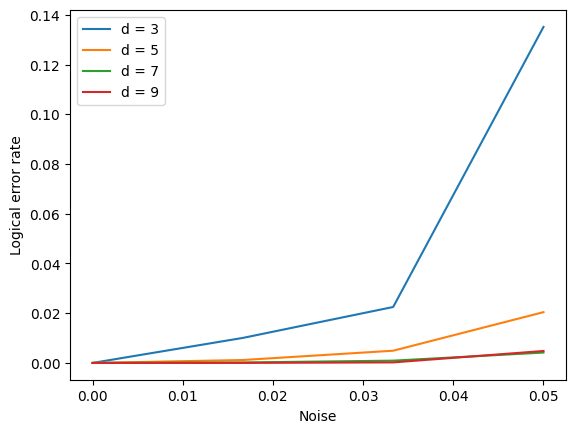

In [99]:
plt.xlabel("Noise")
plt.ylabel("Logical error rate")
plt.plot(prange , log_error_list[0] , label = f"d = {drange[0]}" )
plt.plot(prange , log_error_list[1], label = f"d = {drange[1]}" )

plt.plot(prange , log_error_list[2] , label = f"d = {drange[2]}")
plt.plot(prange , log_error_list[3] , label = f"d = {drange[3]}")
plt.legend()
plt.show()

#### Eventhough the code is expected to work for multiple rounds, I am still not confident that in multiple round scenario we are doing the right thing. 
#### The ideal way is to change the way noise is built , there is a more suitable approach which will be updated next week (20/02/2026))

#### Further plans
#### 1) Extend this approach for surface code and BB code. 
#### 2) Find noise range and type where MFQEC is really benificial.
#### 3) Use MFQEC-MBQEC concatenated approach
#### 4) Write a fast code in Qutip for MFQEC to study coherent errors faithfully.